In [89]:
# Imports
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit, Aer, execute
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
# qiskit ignis is deprecated. Verification has been migrated to qiskit experiments
from qiskit_experiments.library import StateTomography
from qiskit_experiments.library.tomography import StateTomographyAnalysis

import matplotlib.pyplot as plt
from qiskit.quantum_info import partial_trace
from qiskit.quantum_info.states import DensityMatrix

In [90]:
def depolarizing_channel( qc: QuantumCircuit, p: float, system: QuantumRegister, ancillae: list) -> QuantumCircuit:
    """Returns a copy of the quantum circuit passed in with the depolarizing channel at the end.
    Makes a copy of the circuit passed in and returns a new circuit with the oscillating gates. Input circuit is not changed.
    
    Args:
        qc (QuantumCircuit): The quantum circuit to make a copy of and put the depolarizing channel onto.
        p (float): the probability for the channel between 0 and 1.
        system (QuantumRegister): system qubit
        ancillae (list): list of QuantumRegisters for the ancillary qubits. Ancillary qubits are used for the control qubits in the order x, y, then z.

    Returns:
        A QuantumCircuit object
    """
    # Make a copy of the circuit passed in. This circuit will have the depolarizing gates added to the end and then be returned.
    dc = qc.copy()

    # Calculate the theta value which will be used to initialize the ancillary bits to the desired state.
    theta = 1/2 * np.arccos(1-2*p)

    # Initialize ancillary bits
    dc.ry(theta, ancillae[0])
    dc.ry(theta, ancillae[1])
    dc.ry(theta, ancillae[2])

    # Apply depolarizing gates
    dc.cx(ancillae[0], system)
    dc.cy(ancillae[1], system)
    dc.cz(ancillae[2], system)

    return dc
    
def oscillating_circuit(qc: QuantumCircuit, t: float, system: QuantumRegister, ancillae: list) -> QuantumCircuit:
    """Add a simple oscillating circuit, where the probability of measuring a |0> on the system qubit is cos(t).
    Makes a copy of the circuit passed in and returns a new circuit with the oscillating gates. Input circuit is not changed.

    Args:
        qc (QuantumCircuit): The quantum circuit that will have the ocsillating circuit added to it.
        t (float): time
        system (QuantumRegister): Register to use as the system.
        ancillae (list): List of QuantumRegisters to use as the ancillary qubits. Requires 2.

    Returns:
        A QuantumCircuit object
    """
    dc = qc.copy()
    
    # Initialize ancillary bits
    dc.ry(t, ancillae[0])
    dc.ry(t, ancillae[1])
    dc.cx(ancillae[0], system)
    dc.cz(ancillae[1], system)
    return dc

def calc_error_prob(gamma: float, t: float) -> float:
    """Calculate the value of p based on the decay rate (gamma) and time.
    Eq. p = 1 - e^( - gamma * t )

    Args:
        gamma (float): decay rate
        t (float): time

    Returns: 
        float: Probability of error
    """
    return 1 - np.exp(-1 * gamma * t)

In [91]:
# Parameters
t_values = np.linspace(0, 4*np.pi, 24)
decay_rates = np.linspace(0, 0.5, 6)

system = 0
rabi_ancillae = [1,2]
depolarization_ancillae = [3,4,5]
q = QuantumRegister(6, name='q')
initial_circ = QuantumCircuit(q)

# This is a list of the density matricies for each value of p
tomo_rhos = []

backend = Aer.get_backend('qasm_simulator')
fitter = 'linear_inversion'

In [92]:
gamma_line = []
# For each value of p we want to look at, build the circuit with that value of p, run the experiment, and put the result in tomo_rhos
for gamma in decay_rates:
    gamma_rhos = []
    for t in t_values:
        starting_circ = oscillating_circuit(initial_circ, t, q[system], [q[i] for i in rabi_ancillae])
        circ = depolarizing_channel(starting_circ, calc_error_prob(gamma, t), q[system], [q[i] for i in depolarization_ancillae])
        tomoExperiment = StateTomography(circ, measurement_indices=[system])
        results = tomoExperiment.run(backend, fitter=fitter).block_for_results()
        gamma_rhos.append(results.analysis_results("state").value.data)
    gamma_line.append(gamma_rhos)

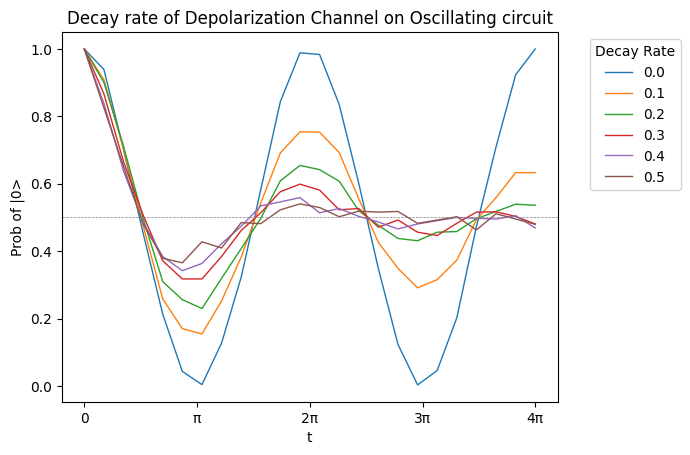

In [93]:
# Plot
for i, gamma in enumerate(decay_rates):
    gamma_00 = []
    for rho in gamma_line[i]:
        gamma_00.append(np.real(rho[0][0]))
    plt.plot(t_values, gamma_00, linewidth=1, label=str(gamma)[0:3])

plt.title("Decay rate of Depolarization Channel on Oscillating circuit")
plt.legend(title="Decay Rate", bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.axhline(y = 0.5, color = 'grey', linestyle = '--', linewidth=0.5) 
plt.xticks(np.linspace(0, 4*np.pi, 5), ['0', 'π', '2π', '3π', '4π'])
plt.xlabel('t')
plt.ylabel('Prob of |0>');

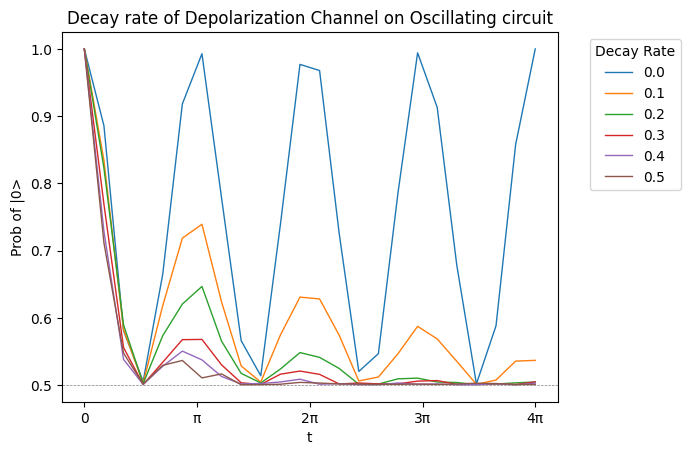

In [96]:
# Plot
for i, gamma in enumerate(decay_rates):
    gamma_00 = []
    for rho in gamma_line[i]:
        rho_squared = np.square(rho)
        gamma_00.append(np.real(np.trace(np.matmul(rho, rho))))
    plt.plot(t_values, gamma_00, linewidth=1, label=str(gamma)[0:3])

plt.title("Decay rate of Depolarization Channel on Oscillating circuit")
plt.legend(title="Decay Rate", bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.axhline(y = 0.5, color = 'grey', linestyle = '--', linewidth=0.5) 
plt.xticks(np.linspace(0, 4*np.pi, 5), ['0', 'π', '2π', '3π', '4π'])
plt.xlabel('t')
plt.ylabel('Prob of |0>');